In [1]:
import json
from evaluate import load
import regex as re
from tqdm import tqdm
import statistics
import matplotlib.pyplot as plt

cjk_char_re = re.compile(r'[\p{Unified_Ideograph}\u3006\u3007]')
punctuation_re = re.compile(r'\p{P}')

cer = load("cer")

# Read JSON data from file
with open("sonoma/common-voice-15-transcriptions.json", "r", encoding="utf-8") as f:
    transcript_json = json.load(f)

def normalize_sentence(s: str) -> str:
    return punctuation_re.sub("", s).replace("噶", "㗎").replace("咧", "呢")

100%|██████████| 2560/2560 [00:00<00:00, 89963.54it/s]


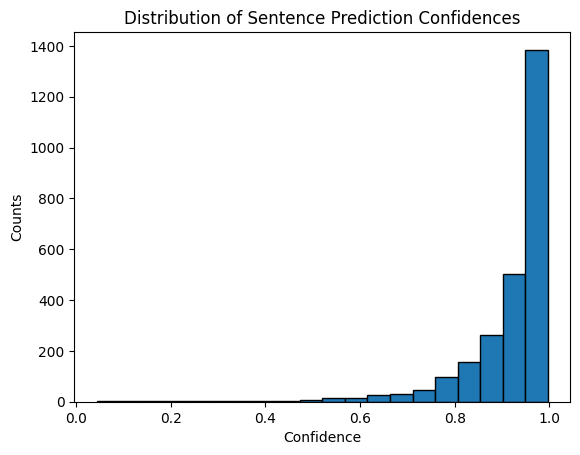

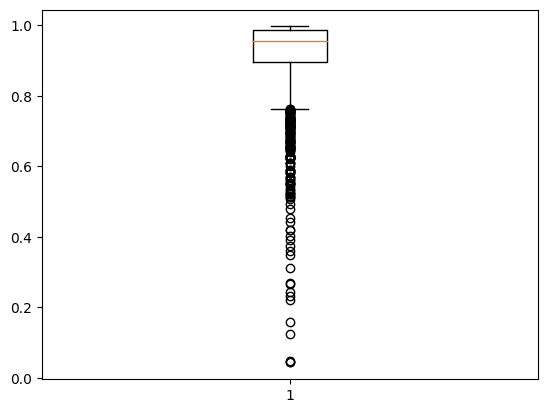

CER Score for best predictions: 0.0741701244813278
CER Score for best predictions (Above Q1=0.897): 0.051
CER Score for best predictions (Above median=0.957): 0.035
CER Score for best predictions (Above Q3=0.987): 0.030


In [12]:
references = []
best_predictions = []
confidences = []

# Iterate over each sentence in the transcript
for entry in tqdm(transcript_json):
    reference = normalize_sentence(entry["sentence"])
    references.append(reference)

    if "segments" in entry:
        # apple
        best_segments = [segment["substring"] for segment in entry["segments"]]
        best_prediction = "".join(best_segments)
        best_predictions.append(best_prediction)

        sentence_confidence = statistics.mean(segment["confidence"] for segment in entry["segments"])
        confidences.append(sentence_confidence)

plt.hist(confidences, bins=20, edgecolor='black')
plt.title('Distribution of Sentence Prediction Confidences')
plt.xlabel('Confidence')
plt.ylabel('Counts')
plt.show()

plt.boxplot(confidences)
plt.show()

cer_score_best = cer.compute(predictions=best_predictions, references=references)
print(f"CER Score for best predictions: {cer_score_best}")

def get_filtered_cer(min_confidence: float):
    best_predictions_filtered = []
    references_filtered = []

    for i, confidence in enumerate(confidences):
        if confidence > min_confidence:
            best_predictions_filtered.append(best_predictions[i])
            references_filtered.append(references[i])

    cer_score_best_filtered = cer.compute(predictions=best_predictions_filtered, references=references_filtered)
    return cer_score_best_filtered

quantiles = statistics.quantiles(confidences)

# Filter out sentences below Q1 confidence
print(f"CER Score for best predictions (Above Q1={quantiles[0]:.3f}): {get_filtered_cer(quantiles[0]):.3f}")

# Filter out sentences below median confidence
print(f"CER Score for best predictions (Above median={quantiles[1]:.3f}): {get_filtered_cer(quantiles[1]):.3f}")

# Filter out sentences below Q3 confidence
print(f"CER Score for best predictions (Above Q3={quantiles[2]:.3f}): {get_filtered_cer(quantiles[2]):.3f}")
